# Lugge glacier geometry 

This notebook plots some basic features of Lugge Glacier. 

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mbticker
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd
import geopandas as gpd
from scipy.interpolate import RegularGridInterpolator
from pyproj import Geod
from scipy.interpolate import interp1d

/usr/local/lib64/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Set paths

In [2]:
base_path = '/data/fast1/lugge/'
thickness_path = base_path + 'thickness/'
smb_path = base_path + 'smb/'
dem_path = base_path + 'dem/'
outlines_path = base_path + 'RGI/outlines/'
centerlines_path = base_path + 'RGI/centerlines/'

## Load datasets

Fairly straightforward except that it seems the RGI-id for the outline does not match with the RGI-id for the centerline. As a workaround, once the outline for Lugge is loaded, we identify the centerline which intersects with that outline, and load that centerline. 

In [3]:
smb_data = pd.read_csv(smb_path + 'prf_glacier_ctl.csv') #read the SMB data

outline_data = gpd.read_file(outlines_path + 'RGI2000-v7.0-G-15_south_asia_east.shp') #RGI outlines
centerline_data = gpd.read_file(centerlines_path + 'RGI2000-v7.0-L-15_south_asia_east.shp') #RGI centerlines

lugge_outline = outline_data.loc[outline_data['rgi_id'].str.contains("15-09534"), 'geometry'].values[0] #find the right outline
intersecting_centerlines = centerline_data[centerline_data.intersects(lugge_outline)] #which centerline intersects?
lugge_centerline = intersecting_centerlines.geometry.values[0]  #extract that linestring

## 2D visualization

Plot elevation, thickness, RGI outline, and RGI flowline together.

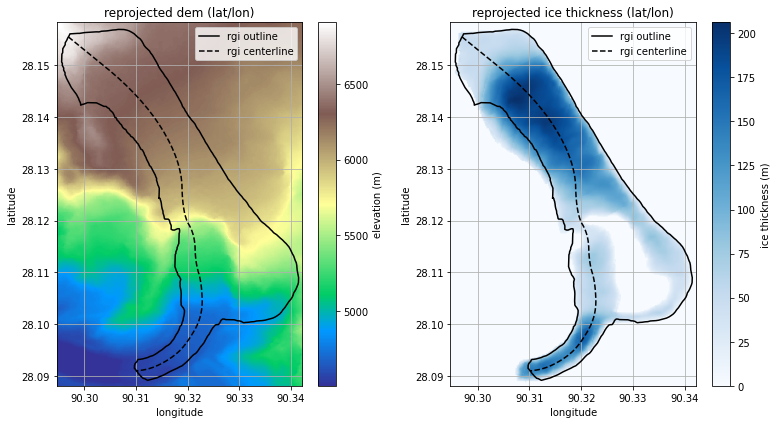

In [4]:
#function to reproject a raster
def reproject_raster(file, target_crs = 'EPSG:4326'):
    with rasterio.open(file) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )
        data = np.empty((height, width), dtype = src.meta['dtype'])

        reproject(
            source = rasterio.band(src, 1),
            destination = data,
            src_transform = src.transform,
            src_crs = src.crs,
            dst_transform = transform,
            dst_crs = target_crs,
            resampling = Resampling.bilinear
        )

    extent = [transform[2], transform[2] + width * transform[0], transform[5] + height * transform[4], transform[5]]
    return data, extent

#reproject dem and thickness map
dem_data, extent = reproject_raster(dem_path + 'SRTMv3_RGI60-15-02373.tif')
thickness_data, _ = reproject_raster(thickness_path + 'RGI60-15-02373_latlon.tif') #extent is the same

#extract rgi outline/centerline coordinates
lugge_x, lugge_y = lugge_outline.exterior.xy #boundary coordinates
centerline_x, centerline_y = lugge_centerline.xy

#plot side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize = (11, 6))

#dem plot
im1 = axes[0].imshow(dem_data, cmap = 'terrain', extent = extent)
axes[0].plot(lugge_x, lugge_y, color = 'black', linewidth = 1.5, label = 'rgi outline') #overlay outline
axes[0].plot(centerline_x, centerline_y, color = 'k', linestyle = 'dashed', label = 'rgi centerline')
axes[0].set_title('reprojected dem (lat/lon)')
axes[0].set_xlabel('longitude')
axes[0].set_ylabel('latitude')
axes[0].grid()
plt.colorbar(im1, ax = axes[0], label = 'elevation (m)')

#thickness map plot
im2 = axes[1].imshow(thickness_data, cmap = 'Blues', extent = extent)
axes[1].plot(lugge_x, lugge_y, color = 'black', linewidth = 1.5, label = 'rgi outline') #overlay outline
axes[1].plot(centerline_x, centerline_y, color = 'k', linestyle = 'dashed', label = 'rgi centerline')
axes[1].set_title('reprojected ice thickness (lat/lon)')
axes[1].set_xlabel('longitude')
axes[1].set_ylabel('latitude')
axes[1].grid()
plt.colorbar(im2, ax = axes[1], label = 'ice thickness (m)')

#add legend
axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

## 1D visualization

Plot surface and bed elevations along the flowline, and plot alongside SMB estimates:

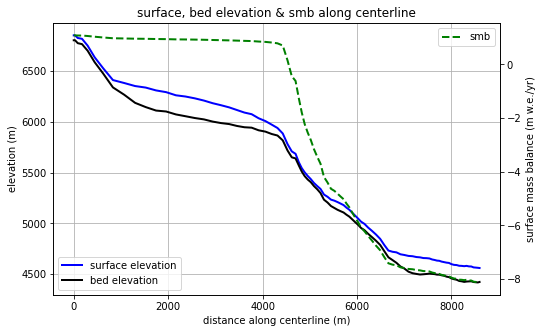

In [5]:
#define wgs84 ellipsoid for accurate distances
geod = Geod(ellps = 'WGS84')

#sample dem (surface elevation) and thickness values along the centerline
with rasterio.open(dem_path + 'SRTMv3_RGI60-15-02373.tif') as dem_src, \
     rasterio.open(thickness_path + 'RGI60-15-02373_latlon.tif') as thick_src:
    
    dem_values = np.array(list(dem_src.sample(zip(centerline_x, centerline_y)))).flatten()
    thickness_values = np.array(list(thick_src.sample(zip(centerline_x, centerline_y)))).flatten()

#compute bed elevation
bed_values = dem_values - thickness_values

#compute cumulative distances in meters
distances = [0] + [geod.inv(centerline_x[i], centerline_y[i], 
                            centerline_x[i + 1], centerline_y[i + 1])[2]
                   for i in range(len(centerline_x) - 1)]
distances = np.cumsum(distances)  #convert to cumulative distance

altitude = np.array(smb_data[' altitude']) 
smb = np.array(smb_data['ave_mb'])

#interpolate smb based on elevation
smb_interp = interp1d(altitude, smb, kind = 'linear', bounds_error = False, fill_value = 'extrapolate')
smb_along_profile = smb_interp(dem_values)

#create figure and twin y-axis
fig, ax1 = plt.subplots(figsize = (8, 5))

#plot surface & bed elevation on primary y-axis
ax1.plot(distances, dem_values, color = 'b', linewidth = 2, linestyle = 'solid', label = 'surface elevation')
ax1.plot(distances, bed_values, color = 'k', linewidth = 2, linestyle = 'solid', label = 'bed elevation')
ax1.set_xlabel('distance along centerline (m)')
ax1.set_ylabel('elevation (m)')
ax1.set_title('surface, bed elevation & smb along centerline')
ax1.grid()
ax1.legend(loc = 'lower left')

#create secondary y-axis for smb
ax2 = ax1.twinx()
ax2.plot(distances, smb_along_profile, color = 'green', linestyle = 'dashed', linewidth = 2, label = 'smb')
ax2.set_ylabel('surface mass balance (m w.e./yr)')
ax2.legend(loc = 'upper right')

plt.show()